In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, sys, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
snp_scheme = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
snp_scheme["#lineage"] = snp_scheme["#lineage"].str.replace("lineage", "")
snp_scheme.rename(columns={"#lineage": "Lineage"}, inplace=True)

lineages = pd.read_csv("../data/combined_lineages_samples.csv", low_memory=False)
solo_results = pd.read_csv("../results/SOLO_Final_Aug2023.csv", header=[1]).query("tier==1")
# solo_results = pd.read_excel("../results/SOLO primary_STATA_ver18Feb2023.xlsx", sheet_name=None)

# if len(solo_results) == 1:
#     solo_results = solo_results[list(solo_results.keys())[0]]
    
# solo_results = solo_results.rename(columns={"variant":"mutation"})
# solo_results["Initial_Confidence_Grading"] = solo_results["Initial_Confidence_Grading"].replace('4) Not assoc w R - interim', '4) Not assoc w R - Interim')
    
import warnings
warnings.filterwarnings(action='ignore')

# utils files are in a separate folder
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
from functools import reduce

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETA",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

drugs_lst = list(drug_abbr_dict.keys())
FQ_drugs_lst = ["Levofloxacin", "Moxifloxacin"]

silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']

# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 12 sheets, one for each model.

In [2]:
def get_unpooled_table_by_tier(drug, tiers_lst, folder, model_prefix):
    
    ################## 1. READ IN RIDGE REGRESSION RESULTS ##################
    model_permute = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_prefix, "model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    ################## 2. READ IN LRT RESULTS ##################
    LRTresults = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_prefix, "LRT_results.csv"))
    LRTresults["mutation"] = LRTresults.mutation.str.replace("lof", "LoF")

    # because the p-values are NaN for the FULL model row, they will be removed, so then the dataframes can be merged using inner
    LRTresults = add_pval_corrections(LRTresults.iloc[1:, ])

    # check that all mutations are represented in both the LRT results and regression model results
    assert len(set(model_permute["mutation"].values).symmetric_difference(LRTresults["mutation"].values)) == 0
    
    # combine results into a single dataframe for easy searching. REMOVE BONFERRONI AND COEFS
    combined_results = model_permute[model_permute.columns[~model_permute.columns.str.contains("|".join(["Bonferroni", "coef"]))]].merge(LRTresults[["mutation", "LRT_pval", "BH_LRT_pval", "LRT_neutral_pval", "BH_LRT_neutral_pval"]]
                                                                                                                  , on="mutation", how="inner")

    combined_results["Tier"] = tiers_lst[-1]

    # columns to return, in the desired order
    keep_cols = ['mutation', 'Tier', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio',
                           #'OR_LB', 'OR_UB', 
                 'pval', 'BH_pval', 'neutral_pval', 'BH_neutral_pval', 'LRT_pval', 'BH_LRT_pval', 'LRT_neutral_pval', 'BH_LRT_neutral_pval']

    keep_cols += ['Num_Isolates', "Mut_R", "Mut_S", "NoMut_S", "NoMut_R", 
                  'R_PPV', 'S_PPV', 'Sens', 'Spec', 'LR+', 'LR-',
                   'R_PPV_LB', 'R_PPV_UB', 'S_PPV_LB', 'S_PPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB',
                   'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'
                   ]

    return combined_results[keep_cols]

In [3]:
def add_significance_category(df, drug, model_path):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
    
    col_name = "regression_confidence"
    df = df.reset_index(drop=True)
    df[["Tier", "synonymous"]] = df[["Tier", "synonymous"]].astype(int)
    
    # lower significance threshold for tier 2 genes and silent variants
    if len(df["Tier"].unique()) == 2 or "withSyn" in model_path:
        thresh = 0.01
    else:
        thresh = 0.05
        
    # relaxed thresholds for pncA
    df.loc[(df["mutation"].str.contains('pncA')) & (df["BH_pval"] <= thresh) & (df["Odds_Ratio"] > 1) & (df["Mut_R"] >= 2) & (df["R_PPV"] >= 0.5), col_name] = "Possible Assoc w R"
    df.loc[(df["mutation"].str.contains('pncA')) & (df["BH_pval"] <= thresh) & (df["Odds_Ratio"] < 1) & (df["Mut_S"] >= 2) & (df["S_PPV"] >= 0.5) & (df["R_PPV"] < 0.4) & (df["R_PPV_UB"] < 0.75), col_name] = "Possible Assoc w S"

    # "regular" thresholds for non-pncA mutations
    # anything without Num_Isolates >= 5 is Uncertain because it's too rare to make conclusions
    df.loc[(~df["mutation"].str.contains('pncA')) & (df["BH_pval"] <= thresh) & (df["Odds_Ratio"] > 1) & (df["Num_Isolates"] >= 5) & (df["R_PPV_LB"] >= 0.25), col_name] = "Possible Assoc w R"
    df.loc[(~df["mutation"].str.contains('pncA')) & (df["BH_pval"] <= thresh) & (df["Odds_Ratio"] < 1) & (df["Num_Isolates"] >= 5) & (df["S_PPV_LB"] >= 0.25), col_name] = "Possible Assoc w S"
    
    # get additional evidence from the LRT to be classified as Assoc w R/S. Only classify Tier 1 here
    df.loc[(df[col_name] == "Possible Assoc w R") & (df["BH_LRT_pval"] <= thresh) & (df["Tier"] == 1), col_name] = "Assoc w R"
    df.loc[(df[col_name] == "Possible Assoc w S") & (df["BH_LRT_pval"] <= thresh) & (df["Tier"] == 1), col_name] = "Assoc w S"
    
    # neutral mutations: not significant in regression AND significant in the neutral LRT test or the permutation neutral test AND present at high enough frequency
    df.loc[(df["BH_pval"] > thresh) & ((df["BH_neutral_pval"] <= thresh) | (df["BH_LRT_neutral_pval"] <= thresh)) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"

    # for silent mutations, use non-FDR p-values to determine neutrality
    df.loc[(df["predicted_effect"].isin(silent_lst)) & (df["pval"] > thresh) & ((df["neutral_pval"] <= thresh) | (df["LRT_neutral_pval"] <= thresh)) & (df["Num_Isolates"] >= 5), col_name] = "Neutral"

    # # phenos = ALL/WHO is the middle part of the path, so split and keep the first and last parts
    # MIC_model_path = "/".join([model_path.split("/")[0], model_path.split("/")[-1]])
    # MIC_model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, "MIC", MIC_model_path, "model_analysis.csv")).query("~mutation.str.contains('PC')")

    # upgrade mutations in the Possible Assoc categories if they have a significant associations with MIC
    # downgrade mutations in the top categories if they DO NOT HAVE significant associations with MIC
    # AT THIS POINT, THE HIGHEST A TIER 2 MUTATION CAN BE IS AT POSSIBLE

    # df = df.merge(MIC_model_analysis[["mutation", "coef", "BH_pval"]].rename(columns={"coef": "MIC_coef", "BH_pval": "BH_MIC_pval"}), on="mutation", how="left")

    # if want to use MIC model results to up- or downgrade mutations
    # mic_evidence_lst = []
    
    # for i, row in df.iterrows():

    #     OR, OR_BH_pval, MIC_coef, BH_MIC_pval = row[["Odds_Ratio", "BH_pval", "MIC_coef", "BH_MIC_pval"]].values
        
    #     if not pd.isnull(MIC_coef) and not pd.isnull(row[col_name]):
                        
    #         if "Possible" in row[col_name] or row["Tier"] == 2:
                
    #             # only upgrade or downgrade if the MIC coefficient is significant
    #             # if it is not significant, then don't make any changes
    #             if BH_MIC_pval < thresh:

    #                 # keep track of mutations that we use MIC evidence for
    #                 mic_evidence_lst.append(row["mutation"])

    #                 # HANDLE POSSIBLE MUTATIONS: if MIC evidence agrees and is significant, upgrade
    #                 # if MIC evidence disagrees or is NOT significant, downgrade
    #                 if OR > 1:
    #                     if MIC_coef > 0:
    #                         df.loc[i, col_name] = "Assoc w R"
    #                     else:
    #                         df.loc[i, col_name] = "Uncertain"

    #                 elif OR < 1:
    #                     if MIC_coef < 0:
    #                         df.loc[i, col_name] = "Assoc w S"
    #                     else:
    #                         df.loc[i, col_name] = "Uncertain"
                            
    # all other are uncertain
    df[col_name] = df[col_name].fillna("Uncertain")
    # df.loc[df["mutation"].isin(mic_evidence_lst), "Use_MIC_Evidence"] = 1
    # df["Use_MIC_Evidence"] = df["Use_MIC_Evidence"].fillna(0).astype(int)
    return df

In [4]:
def add_single_lineage_annotations_to_model(drug, df, folder, model_path):
    '''
    Annotate mutations that are present in a single lineage. Basically just a flag when performing further analyses.
    
    It's done at the lowest level because that's the output of Coll2014. So it will not flag mutations that are all present in L2, unless L2 was the deepest category fast-lineage-caller identified.
    '''
    
    model_matrix = pd.read_pickle(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl"))

    lineages_single_model = lineages.query("~Coll2014.str.contains(',')")
    model_matrix = model_matrix.loc[model_matrix.index.isin(lineages_single_model['Sample_ID'].values)]
    model_matrix = model_matrix.merge(lineages_single_model[["Coll2014", "Sample_ID"]], left_index=True, right_on="Sample_ID")
    
    single_lineage_mutations = {}

    for col in model_matrix.columns:

        if col not in ["Sample_ID", "Coll2014"]:

            mutation_lineages = np.unique(model_matrix.loc[model_matrix[col]==1]["Coll2014"].values)

            # there is only one lineage present
            if len(mutation_lineages) == 1:
                single_lineage_mutations[col] = mutation_lineages[0]
    
    # add lineage annotations to dataframe. Only mutations that are in the model matrix are in this dictionary
    df["single_lineage"] = df["mutation"].map(single_lineage_mutations)
    return df

In [5]:
def export_binary_analyses(drugs_lst, read_folder, write_folder, analyses_lst, pooled_model_variants=False):
    '''
    pooled_model_variants boolean indicates whether to get the statistics for the non-lof, non-inframe mutations from the unpooled models or the pooled models
    '''
    
    if not os.path.isdir(f"../results/{write_folder}"):
        os.mkdir(f"../results/{write_folder}")
    
    for drug in np.sort(drugs_lst):
        
        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):
            
            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes or WHO phenotypes
            if os.path.isfile(os.path.join(analysis_dir, drug, read_folder, model_path, "model_analysis.csv")):
                            
                tiers_lst = [["1", "2"] if "1+2" in model_path else ["1"]][0]
                phenos_name = ["ALL" if "phenos=ALL" in model_path else "WHO"][0]
                
                # if "dropAF_withSyn_unpooled" in model_path:
                phenos_name = ["ALL" if "ALL" in model_path else "WHO"][0]
                add_analysis = get_unpooled_table_by_tier(drug, tiers_lst, read_folder, model_path)
                
                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                
                add_analysis = add_analysis[add_analysis.columns[~add_analysis.columns.str.contains("|".join(["coef", "Bonferroni"]))]]
                add_analysis = add_significance_category(add_analysis, drug, model_path)

                # add annotation denoting whether a mutation is only present in a single lineage
                add_analysis = add_single_lineage_annotations_to_model(drug, add_analysis, read_folder, model_path)

                # exclude mutations that are already covered in earlier models
                exclude_mutations = []
                
                # for models with synonymous mutations, keep only the data for the synonymous ones
                # the data for nonsyn mutations will come from the noSyn models
                if "withSyn" in model_path:
                    try:
                        exclude_mutations += list(pd.read_pickle(os.path.join(analysis_dir, drug, read_folder, model_path.replace("withSyn", "noSyn"), "model_matrix.pkl")).columns)
                    except:
                        pass
                        
                # select which model results to keep for mutations (non-LoF, non-inframe) tested in both the pooled and unpooled models
                # if pooled_model_variants = True, keep the stats from the pooled model. else, keep the stats from the unpooled model
                if pooled_model_variants:

                    # no pooled + synonymous models
                    if "unpooled" in model_path and "noSyn" in model_path:
                        try:
                            exclude_mutations += list(pd.read_pickle(os.path.join(analysis_dir, drug, read_folder, model_path.replace("unpooled", "poolSeparate"), "model_matrix.pkl")).columns)
                        except:
                            pass
                            
                else:
                    # exclude mutations in the pooled model so that we keep the values estimated in the unpooled model
                    if "poolSeparate" in model_path and "noSyn" in model_path:
                        try:
                            exclude_mutations += list(pd.read_pickle(os.path.join(analysis_dir, drug, read_folder, model_path.replace("poolSeparate", "unpooled"), "model_matrix.pkl")).columns)
                        except:
                            pass
                            
                add_analysis = add_analysis.query("mutation not in @exclude_mutations")

                # the phenotype category is only relevant for the binary analysis
                if read_folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "phenos=ALL" in model_path else "WHO"][0]

                add_analysis.rename(columns={"confidence": "confidence_V1",
                                             "Mut_R": "Present_R",
                                             "NoMut_R": "Absent_R",
                                             "Mut_S": "Present_S",
                                             "NoMut_S": "Absent_S"
                                            }, inplace=True)

                if len(add_analysis) > 0:
                    all_analyses[model_path.replace("phenos=", "").replace("/", ",").replace("tiers=", "T").replace("dropAF_", "").replace("encodeAF_", "").replace("binarizeAF", "")] = add_analysis
    
        with pd.ExcelWriter(f"../results/{write_folder}/{drug}.xlsx") as file:
            for key, val in all_analyses.items():
                val.to_excel(file, sheet_name=key, index=False)
                    
        print(f"Finished {len(all_analyses)} analyses for {drug}")

In [8]:
binary_analyses_lst = [
                        ########### Tier 1, WHO phenos ###########
                        "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                        "tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                        "tiers=1/phenos=WHO/dropAF_withSyn_unpooled",
                        ########### Tier 1, ALL phenos ###########
                        "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                        "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                        "tiers=1/phenos=ALL/dropAF_withSyn_unpooled",
                      ]

binary_analyses_encodeAF_lst = [
                        ########### Tiers 1, WHO phenos ###########
                        "tiers=1/phenos=WHO/encodeAF_noSyn_unpooled",
                        "tiers=1/phenos=WHO/encodeAF_noSyn_poolSeparate",
                        "tiers=1/phenos=WHO/encodeAF_withSyn_unpooled",
                        ########### Tiers 1 + 2, ALL phenos ###########
                        "tiers=1/phenos=ALL/encodeAF_noSyn_unpooled",
                        "tiers=1/phenos=ALL/encodeAF_noSyn_poolSeparate",
                        "tiers=1/phenos=ALL/encodeAF_withSyn_unpooled",
                      ]

export_binary_analyses(drugs_lst, "BINARY", "BINARY_POOL", binary_analyses_lst, pooled_model_variants=True)
export_binary_analyses(drugs_lst, "BINARY", "BINARY", binary_analyses_lst, pooled_model_variants=False)

# export_binary_analyses(FQ_drugs_lst, "BINARY", "BINARY_AF_POOL", binary_analyses_encodeAF_lst, pooled_model_variants=True)
# export_binary_analyses(FQ_drugs_lst, "BINARY", "BINARY_AF", binary_analyses_encodeAF_lst, pooled_model_variants=False)

Finished 6 analyses for Amikacin
Finished 6 analyses for Bedaquiline
Finished 6 analyses for Capreomycin
Finished 6 analyses for Clofazimine
Finished 6 analyses for Delamanid
Finished 6 analyses for Ethambutol
Finished 6 analyses for Ethionamide
Finished 6 analyses for Isoniazid
Finished 6 analyses for Kanamycin
Finished 6 analyses for Levofloxacin
Finished 5 analyses for Linezolid
Finished 6 analyses for Moxifloxacin
Finished 3 analyses for Pretomanid
Finished 6 analyses for Pyrazinamide
Finished 6 analyses for Rifampicin
Finished 6 analyses for Streptomycin
Finished 6 analyses for Amikacin
Finished 6 analyses for Bedaquiline
Finished 6 analyses for Capreomycin
Finished 6 analyses for Clofazimine
Finished 6 analyses for Delamanid
Finished 6 analyses for Ethambutol
Finished 6 analyses for Ethionamide
Finished 6 analyses for Isoniazid
Finished 6 analyses for Kanamycin
Finished 6 analyses for Levofloxacin
Finished 5 analyses for Linezolid
Finished 6 analyses for Moxifloxacin
Finished 3 a

In [156]:
# drugs_use_mic = []

# for drug in drugs_lst:

#     results = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=None)

#     for key, df in results.items():
#         if len(df.query("Use_MIC_Evidence == 1")) > 0:
#             drugs_use_mic.append(drug)
#             break

# print(len(drugs_use_mic))

7


In [159]:
# pd.DataFrame.from_dict(mut_use_mic, orient='index').T

,Pyrazinamide,Amikacin,Ethambutol,Bedaquiline,Rifampicin,Isoniazid,Ethionamide
0,ALL_pncA_p.Glu15*,WHO_eis_p.Met1?,WHO_embB_c.2499G>A,WHO_Rv0678_p.Cys46Arg,ALL_rpoB_p.Val695Leu,WHO_inhA_c.-100C>A,WHO_ethA_p.His281Pro
1,ALL_pncA_c.3G>A,None,ALL_ubiA_p.Glu273Asp,WHO_Rv0678_p.Ile67Ser,None,ALL_katG_p.Phe167Cys,WHO_ethA_p.Trp256fs
2,None,None,ALL_embC_c.-900C>T,WHO_mmpL5_p.Thr794Ile,None,None,WHO_ethA_p.Thr321Pro
3,None,None,ALL_embB_c.3165C>A,WHO_Rv0678_p.Gln51fs,None,None,WHO_ethA_p.Leu225fs
4,None,None,ALL_embB_c.2499G>A,None,None,None,WHO_ethA_p.Tyr211Ser
5,None,None,None,None,None,None,WHO_ethA_p.Asp464fs
6,None,None,None,None,None,None,WHO_mshA_lof
7,None,None,None,None,None,None,ALL_inhA_c.-100C>A
8,None,None,None,None,None,None,ALL_inhA_c.9A>C


In [9]:
def final_processing_single_dataset_results(df, drug, tiers_lst=[1]):

    df["mutation"] = df.mutation.str.replace("lof", "LoF")
    df["predicted_effect"] = df.predicted_effect.str.replace("lof", "LoF")

    df.loc[df['regression_confidence'] == 'Possible Assoc w R', 'regression_confidence'] = 'Assoc w R - Interim'
    df.loc[df['regression_confidence'] == 'Possible Assoc w S', 'regression_confidence'] = 'Assoc w S - Interim'

    # any mutations that were not in any regression model are added back in here as Uncertain with additional info in the Reason column
    missing_mut_df = solo_results.query("drug==@drug & tier in @tiers_lst & variant not in @df.mutation.values")[['variant', 'effect']].rename(columns={'variant': 'mutation', 'effect': 'predicted_effect'})
    missing_mut_df['regression_confidence'] = 'Uncertain'
    missing_mut_df['Reason'] = 'Not_Graded'

    return pd.concat([df, missing_mut_df], axis=0)
    
    
    
    
def get_all_results_single_drug(drug, excel_dir):

    full_results_excel = pd.read_excel(f"../results/{excel_dir}/{drug}.xlsx", sheet_name=None)
    # del_cols = ["Phenos", "pool_type", "synonymous", "confidence_V1", "pval", "neutral_pval", "LRT_pval", "LRT_neutral_pval"]
    del_cols = ["Phenos", "pool_type", "synonymous", "confidence_V1", "LRT_pval"]
    
    WHO_combined = []
    ALL_combined = []

    for name, df in full_results_excel.items():

        df = df[df.columns[~df.columns.isin(del_cols)]]
        
        if "WHO" in name:
            WHO_combined.append(df)
        elif "ALL" in name:
            ALL_combined.append(df)
        else:
            print(name)

    # no ALL phenotype for Pretomanid. 
    # For one of the WHO models for Linezolid, pooling mutations doesn't make a difference, so the number of models is different between WHO and ALL
    if drug not in ["Pretomanid", "Linezolid"]:
        assert len(WHO_combined) == len(ALL_combined)
        assert len(pd.concat(WHO_combined)) == len(pd.concat(WHO_combined).drop_duplicates("mutation"))
        assert len(pd.concat(ALL_combined)) == len(pd.concat(ALL_combined).drop_duplicates("mutation"))

    if drug != 'Pretomanid':
        ALL_combined = pd.concat(ALL_combined)
        # ALL_combined = final_processing_single_dataset_results(ALL_combined, drug, tiers_lst=[1])
        
    # fix LoF naming for easy comparison to SOLO
    WHO_combined = pd.concat(WHO_combined)
    # WHO_combined = final_processing_single_dataset_results(WHO_combined, drug, tiers_lst=[1])

    return WHO_combined, ALL_combined

In [10]:
def clean_WHO_results_write_to_csv(drug, in_folder, out_folder, tiers_lst=[1]):

    cols_lst = ['Odds_Ratio', 'pval', 'BH_pval', 'neutral_pval', 'BH_neutral_pval', 'BH_LRT_pval', 'LRT_neutral_pval', 'BH_LRT_neutral_pval',
       'Num_Isolates', 'Present_R', 'Present_S', 'Absent_S', 'Absent_R', 'R_PPV',
       'S_PPV', 'Sens', 'Spec', 'R_PPV_LB', 'R_PPV_UB', 'S_PPV_LB',
       'S_PPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'regression_confidence', 'single_lineage', ]#'Use_MIC_Evidence']
    
    WHO_results_single_drug, ALL_results_single_drug = get_all_results_single_drug(drug, in_folder)

    WHO_results_single_drug = pd.concat([WHO_results_single_drug[["mutation", "predicted_effect"]], 
                                        WHO_results_single_drug[cols_lst], 
                                        #WHO_results_single_drug[['MIC_coef', 'BH_MIC_pval']]
                                       ], axis=1)

    
    WHO_results_single_drug["mutation"] = WHO_results_single_drug.mutation.str.replace("lof", "LoF")
    WHO_results_single_drug["predicted_effect"] = WHO_results_single_drug.predicted_effect.str.replace("lof", "LoF")

    # any mutations that were not in any regression model are added back in here as Uncertain with additional info in the Reason column
    missing_mut_df = solo_results.query("drug==@drug & tier in @tiers_lst & variant not in @WHO_results_single_drug.mutation.values")[['variant', 'effect']].rename(columns={'variant': 'mutation', 'effect': 'predicted_effect'})
    missing_mut_df['regression_confidence'] = 'Uncertain'
    missing_mut_df['Reason'] = 'Not Graded'

    save_df = pd.concat([WHO_results_single_drug, missing_mut_df], axis=0).rename(columns=dict(zip(cols_lst, [f"WHO_{col}" for col in cols_lst]))).sort_values("WHO_Odds_Ratio", ascending=False)

    # make this column so that it can be used like for all the other drugs. It's just a copy of WHO_regression_confidence because there is no ALL dataset
    save_df["FINAL CONFIDENCE GRADING"] = save_df["WHO_regression_confidence"]

    # rename columns for consistency with SOLO, then save
    save_df.rename(columns={'WHO_regression_confidence': 'Initial confidence grading WHO dataset'}).to_csv(f"../results/{out_folder}/{drug}.csv", index=False)

In [11]:
def combine_WHO_ALL_results_write_to_csv(drug, in_folder, out_folder, tiers_lst=[1]):

    WHO_results_single_drug, ALL_results_single_drug = get_all_results_single_drug(drug, in_folder)

    # # add upgrades if a variant is part of Lof and inframe pooled mutations
    # WHO_results_single_drug = upgrade_components_of_pooled_variants(WHO_results_single_drug)
    # ALL_results_single_drug = upgrade_components_of_pooled_variants(ALL_results_single_drug)

    all_mutations = list(set(WHO_results_single_drug.mutation).union(set(ALL_results_single_drug.mutation)))

    R_interim_lst = []
    R_lst = []
    S_interim_lst = []
    S_lst = []
    uncertain_lst = []
    discrepant_or_lst = []
    neutral_lst = []
    
    for mutation in all_mutations:

        # if a mutation was not tested in a model, assign it to Ungraded for the purposes of combining results. It will still be NaN in the other columns of the dataframe though
        if len(ALL_results_single_drug.query("mutation==@mutation")) == 0:
            ALL_conf = "Ungraded"
        else:
            ALL_conf = ALL_results_single_drug.query("mutation==@mutation")["regression_confidence"].values[0]

        if len(WHO_results_single_drug.query("mutation==@mutation")) == 0:
            WHO_conf = "Ungraded"
        else:
            WHO_conf = WHO_results_single_drug.query("mutation==@mutation")["regression_confidence"].values[0]        

        # regardless of what the WHO grading is, if ALL is uncertain, keep uncertain because ALL is a bigger, more representative dataset
        if ALL_conf == "Uncertain":
            uncertain_lst.append(mutation)

        # if the two phenotypic categories disagree in the sign of the OR (and have significant ORs), make uncertain
        # this includs both the Possible and strict categories
        if "Assoc w R" in WHO_conf and "Assoc w S" in ALL_conf:
            uncertain_lst.append(mutation)
            discrepant_or_lst.append(mutation)

        if "Assoc w R" in ALL_conf and "Assoc w S" in WHO_conf:
            uncertain_lst.append(mutation)
            discrepant_or_lst.append(mutation)

        # because ALL is a bigger, more representative dataset, make interim if WHO = uncertain/neutral and ALL = assoc
        # if ALL is in the possible category, however, downgrade to uncertain
        if WHO_conf in ["Uncertain", "Neutral", "Ungraded"]:
            if ALL_conf == 'Assoc w R':
                R_interim_lst.append(mutation)
            elif ALL_conf == 'Assoc w S':
                S_interim_lst.append(mutation)
            elif "Possible" in ALL_conf:
                uncertain_lst.append(mutation)
            elif ALL_conf == "Neutral":
                neutral_lst.append(mutation)

        # upgrade mutations that are possible in WHO and assoc w R/S in ALL to assoc
        if WHO_conf == "Possible Assoc w R":
            if ALL_conf == "Assoc w R":
                R_lst.append(mutation)

        if WHO_conf == "Possible Assoc w S":
            if ALL_conf == "Assoc w S":
                S_lst.append(mutation)

        # downgrade mutations that are assoc w R/S in WHO but possible in ALL to interim
        if ALL_conf == "Possible Assoc w R":
            if WHO_conf == "Assoc w R":
                R_interim_lst.append(mutation)

        if ALL_conf == "Possible Assoc w S":
            if WHO_conf == "Assoc w S":
                S_interim_lst.append(mutation)

        if "Possible" in WHO_conf and "Possible" in ALL_conf:
            uncertain_lst.append(mutation)

    # check that the 4 up/downgrade lists are mutually exclusive (otherwise would indicate a bug)
    assert len(set(R_interim_lst).intersection(S_interim_lst)) == 0
    assert len(set(R_interim_lst).intersection(uncertain_lst)) == 0
    assert len(set(S_interim_lst).intersection(uncertain_lst)) == 0
    assert len(set(R_interim_lst).intersection(neutral_lst)) == 0
    assert len(set(S_interim_lst).intersection(neutral_lst)) == 0
    assert len(set(uncertain_lst).intersection(neutral_lst)) == 0
    assert len(set(R_lst).intersection(S_lst)) == 0
    assert len(set(R_interim_lst).intersection(R_lst)) == 0
    assert len(set(S_interim_lst).intersection(S_lst)) == 0

    # all columns to keep in each of the WHO and ALL dataset dataframes
    cols_lst = ['Odds_Ratio', 'pval', 'BH_pval', 'neutral_pval', 'BH_neutral_pval', 'BH_LRT_pval', 'LRT_neutral_pval', 'BH_LRT_neutral_pval',
       'Num_Isolates', 'Present_R', 'Present_S', 'Absent_S', 'Absent_R', 'R_PPV',
       'S_PPV', 'Sens', 'Spec', 'R_PPV_LB', 'R_PPV_UB', 'S_PPV_LB',
       'S_PPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB', 'Spec_UB', 'regression_confidence', 'single_lineage']#, 'AddGrading']
                
    WHO_final = WHO_results_single_drug
    WHO_final = pd.concat([WHO_final[["mutation", "predicted_effect"]], 
                           WHO_final[cols_lst], 
                           #WHO_final[['MIC_coef', 'BH_MIC_pval']]
                          ], axis=1)
    WHO_final.rename(columns=dict(zip(cols_lst, [f"WHO_{col}" for col in cols_lst])), inplace=True)

    ALL_final = ALL_results_single_drug
    ALL_final = pd.concat([ALL_final[["mutation", "predicted_effect"]], 
                           ALL_final[cols_lst],
                           #ALL_final[['MIC_coef', 'BH_MIC_pval']]
                          ], axis=1)
    ALL_final.rename(columns=dict(zip(cols_lst, [f"ALL_{col}" for col in cols_lst])), inplace=True)

    final_df = WHO_final.merge(ALL_final, on=["mutation", "predicted_effect"], how="outer").drop_duplicates().reset_index(drop=True)
    
    # start with WHO confidences first, then make up- or downgrades depending on the ALL results
    final_df["regression_confidence"] = final_df["WHO_regression_confidence"].fillna(final_df["ALL_regression_confidence"])

    # upgrades to interim
    final_df.loc[final_df["mutation"].isin(R_interim_lst), "regression_confidence"] = "Assoc w R - Interim"
    final_df.loc[final_df["mutation"].isin(R_lst), "regression_confidence"] = "Assoc w R"

    final_df.loc[final_df["mutation"].isin(S_interim_lst), "regression_confidence"] = "Assoc w S - Interim"
    final_df.loc[final_df["mutation"].isin(S_lst), "regression_confidence"] = "Assoc w S"
    
    final_df.loc[final_df["mutation"].isin(neutral_lst), "regression_confidence"] = "Neutral"

    # downgrades to uncertain and all remaining possibles downgraded to uncertain
    final_df.loc[(final_df["mutation"].isin(uncertain_lst)) | (final_df["regression_confidence"].str.contains("Possible")), "regression_confidence"] = "Uncertain"

    # rename columns for consistency with SOLO
    final_df.rename(columns={'WHO_regression_confidence': 'Initial confidence grading WHO dataset',
                             'ALL_regression_confidence': 'Initial confidence grading ALL dataset',
                             'regression_confidence': 'FINAL CONFIDENCE GRADING'
                            }, inplace=True)

    final_df.loc[final_df["mutation"].isin(discrepant_or_lst), "Reason"] = "Discrepant ORs"
    
    # check that no mutations have been duplicated
    assert len(final_df.mutation.unique()) == len(final_df)

    # fix LoF naming
    final_df["mutation"] = final_df.mutation.str.replace("lof", "LoF")
    final_df["predicted_effect"] = final_df.predicted_effect.str.replace("lof", "LoF")

    # reorder columns so that the MIC columns are at the end
    final_df = final_df[np.concatenate([final_df.columns[~final_df.columns.str.contains('MIC')],  final_df.columns[final_df.columns.str.contains('MIC')]])]

    # any mutations that were not in any regression model are added back in here as Uncertain with additional info in the Reason column
    missing_mut_df = solo_results.query("drug==@drug & tier in @tiers_lst & variant not in @final_df.mutation.values")[['variant', 'effect']].rename(columns={'variant': 'mutation', 'effect': 'predicted_effect'})
    missing_mut_df['FINAL CONFIDENCE GRADING'] = 'Uncertain'
    missing_mut_df['Reason'] = 'Not Graded'
    
    pd.concat([final_df, missing_mut_df], axis=0).sort_values("WHO_Odds_Ratio", ascending=False).to_csv(f"../results/{out_folder}/{drug}.csv", index=False)

In [12]:
def write_results_for_all_drugs(drugs_lst, in_folder, out_folder, tiers_lst=[1]):

    if not os.path.isdir(f"../results/{out_folder}"):
        os.mkdir(f"../results/{out_folder}")
    
    for drug in np.sort(drugs_lst):
    
        if drug == "Pretomanid":
            clean_WHO_results_write_to_csv(drug, in_folder, out_folder, tiers_lst=[1])            
        else:
            combine_WHO_ALL_results_write_to_csv(drug, in_folder, out_folder, tiers_lst=[1])
    
        print(drug)

# Write Results for Pooled and Unpooled Models for All Drugs

In [13]:
write_results_for_all_drugs(FQ_drugs_lst, "BINARY_AF", "UNPOOLED_AF", tiers_lst=[1])
write_results_for_all_drugs(FQ_drugs_lst, "BINARY_AF_POOL", "POOLED_AF", tiers_lst=[1])

Levofloxacin
Moxifloxacin
Levofloxacin
Moxifloxacin


In [14]:
write_results_for_all_drugs(drugs_lst, "BINARY", "UNPOOLED", tiers_lst=[1])

Amikacin
Bedaquiline
Capreomycin
Clofazimine
Delamanid
Ethambutol
Ethionamide
Isoniazid
Kanamycin
Levofloxacin
Linezolid
Moxifloxacin
Pretomanid
Pyrazinamide
Rifampicin
Streptomycin


In [15]:
write_results_for_all_drugs(drugs_lst, "BINARY_POOL", "POOLED", tiers_lst=[1])

Amikacin
Bedaquiline
Capreomycin
Clofazimine
Delamanid
Ethambutol
Ethionamide
Isoniazid
Kanamycin
Levofloxacin
Linezolid
Moxifloxacin
Pretomanid
Pyrazinamide
Rifampicin
Streptomycin


# Compare Gradings between Pooled and Unpooled Models

In [16]:
def resolve_pooled_unpooled_model_results(drug, pooled_dir="POOLED", unpooled_dir="UNPOOLED", include_silent=False):
    '''
    This function returns a dataframe of variants with different gradings between pooled and unpooled models. These variants are NOT LoF or inframe variants, nor the component variants of pooled LoF and inframe variants.

    There are several variants that are graded Neutral in one model and Uncertain in another. These are converted to Uncertain

    In the final results, we prioritize the results from unpooled models, then update the final confidence grading for any variants with differing gradings between pooled and unpooled models. These final results are then saved to the results/FINAL folder.
    '''
    
    final_col = 'RESOLVED FINAL GRADING'

    pooled_results = pd.read_csv(f"../results/{pooled_dir}/{drug}.csv")
    unpooled_results = pd.read_csv(f"../results/{unpooled_dir}/{drug}.csv")

    # there should not be any differences in the mutations in the two sets. These lists exclude all pooled mutations and all components of pooled variants
    # i.e. there are no LoF variants and also no frameshift variants because they are components of LoF variants
    assert len(set(pooled_results.mutation).symmetric_difference(set(unpooled_results.mutation))) == 0

    if not include_silent:
        pooled_results = pooled_results.query("predicted_effect not in @silent_lst]")
        unpooled_results = unpooled_results.query("predicted_effect not in @silent_lst")

    combined_df = unpooled_results[["mutation", "FINAL CONFIDENCE GRADING"]].merge(pooled_results[["mutation", "FINAL CONFIDENCE GRADING"]], on="mutation", suffixes=["_unpooled", "_pooled"], how="outer")

    # most of the variants have the same grading in pooled and unpooled models, so take that one
    combined_df.loc[combined_df['FINAL CONFIDENCE GRADING_unpooled'] == combined_df['FINAL CONFIDENCE GRADING_pooled'], final_col] = combined_df['FINAL CONFIDENCE GRADING_unpooled']

    # add solo gradings for comparison
    combined_df = combined_df.merge(solo_results.query("drug==@drug")[["variant", "FINAL CONFIDENCE GRADING"]].rename(columns={"variant": "mutation", "FINAL CONFIDENCE GRADING": "SOLO_FINAL_GRADING"}), how="left")

    # print the drug name if there are differences for some variants that are NOT Uncertain/Neutral discrepancies
    diff_df = combined_df.loc[pd.isnull(combined_df[final_col])].reset_index(drop=True)
    del combined_df
    
    # print the drug name if there are differences for some variants that are NOT Uncertain/Neutral discrepancies
    if len(diff_df.loc[~((diff_df['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (diff_df['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]) > 0:
        print(drug)
    
    # resolve differences
    # can assume that there are no cases of one being assoc w R and the other being assoc w S because already assigned those to uncertain within each model above
    for i, row in diff_df.iterrows():

        # only variants with differences between pooled and unpooled models have NaNs in this column
        if pd.isnull(row[final_col]):

            if 'Uncertain' in [row['FINAL CONFIDENCE GRADING_unpooled'], row['FINAL CONFIDENCE GRADING_pooled']]: 
    
                # make Uncertain + Neutral (regardless of order) = Neutral
                if 'Neutral' in [row['FINAL CONFIDENCE GRADING_unpooled'], row['FINAL CONFIDENCE GRADING_pooled']]: 
                    diff_df.loc[i, final_col] = 'Neutral'
                    
                # if one is uncertain and the other is interim, then make uncertain
                elif 'Interim' in row['FINAL CONFIDENCE GRADING_unpooled'] or 'Interim' in row['FINAL CONFIDENCE GRADING_pooled']:
                    diff_df.loc[i, final_col] = 'Uncertain'
    
                # if the other does not contain Interim, then it must be Assoc w R/S, so make the final grading interim
                else:
                    if row['FINAL CONFIDENCE GRADING_unpooled'] == 'Uncertain':
                        diff_df.loc[i, final_col] = row['FINAL CONFIDENCE GRADING_pooled'] + ' - Interim'
                    else:
                        diff_df.loc[i, final_col] = row['FINAL CONFIDENCE GRADING_unpooled'] + ' - Interim'
        
            # if one is interim and other is Assoc w R/S, then make interim
            else:
                if 'Interim' in row['FINAL CONFIDENCE GRADING_unpooled'] and 'Interim' not in row['FINAL CONFIDENCE GRADING_pooled']:
                    diff_df.loc[i, final_col] = row['FINAL CONFIDENCE GRADING_unpooled']
                
                elif 'Interim' in row['FINAL CONFIDENCE GRADING_pooled'] and 'Interim' not in row['FINAL CONFIDENCE GRADING_unpooled']:
                    diff_df.loc[i, final_col] = row['FINAL CONFIDENCE GRADING_pooled']
            
    if len(diff_df) > 0:
        return diff_df
    else:
        return None

In [17]:
# cool, no differences between pooled and unpooled for FQs, excluding Uncertain and Neutral mutations
pooled_unpooled_resolved_FQ_encodeAF = {}

for drug in FQ_drugs_lst:
    pooled_unpooled_resolved_FQ_encodeAF[drug] = resolve_pooled_unpooled_model_results(drug, pooled_dir="POOLED_AF", unpooled_dir="UNPOOLED_AF", include_silent=True)

In [75]:
pooled_unpooled_resolved = {}

for drug in np.sort(drugs_lst):
    pooled_unpooled_resolved[drug] = resolve_pooled_unpooled_model_results(drug, pooled_dir="POOLED", unpooled_dir="UNPOOLED", include_silent=True)

Bedaquiline
Ethambutol
Ethionamide
Isoniazid
Kanamycin
Pyrazinamide
Rifampicin


In [65]:
drug = 'Bedaquiline'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,Rv0678_p.Asn70Asp,Assoc w R - Interim,Assoc w R,Assoc w R - Interim,2) Assoc w R - Interim


In [76]:
drug = 'Ethambutol'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
1,ubiA_p.Ala237Val,Uncertain,Assoc w R,Assoc w R - Interim,3) Uncertain significance


In [77]:
drug = 'Ethionamide'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,inhA_c.-770T>C,Assoc w R,Assoc w R - Interim,Assoc w R - Interim,2) Assoc w R - Interim
1,inhA_c.-796C>T,Uncertain,Assoc w R,Assoc w R - Interim,3) Uncertain significance
4,ethA_p.Cys403Trp,Assoc w R - Interim,Uncertain,Uncertain,3) Uncertain significance


In [78]:
drug = 'Isoniazid'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,katG_p.Gln525Pro,Assoc w R,Assoc w R - Interim,Assoc w R - Interim,3) Uncertain significance


In [82]:
results_all_drugs.query("mutation=='katG_p.Ser140Asn'")[['mutation', 'WHO_S_PPV_LB', 'ALL_S_PPV_LB']]

,mutation,WHO_S_PPV_LB,ALL_S_PPV_LB
19304,katG_p.Ser140Asn,0.157013,0.125761


In [87]:
results_all_drugs.query("mutation=='katG_p.Ser140Asn'")[['mutation', 'WHO_Present_S', 'WHO_Present_R', 'WHO_S_PPV', 'ALL_Present_S', 'ALL_Present_R', 'ALL_S_PPV']]

,mutation,WHO_Present_S,WHO_Present_R,WHO_S_PPV,ALL_Present_S,ALL_Present_R,ALL_S_PPV
19304,katG_p.Ser140Asn,4.0,4.0,0.5,6.0,13.0,0.315789


In [89]:
drug = 'Kanamycin'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,whiB7_p.Leu42Pro,Assoc w S - Interim,Uncertain,Uncertain,3) Uncertain significance


In [90]:
drug = 'Pyrazinamide'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,pncA_p.Val93Ala,Assoc w R,Uncertain,Assoc w R - Interim,2) Assoc w R - Interim
1,pncA_p.Val155Ala,Assoc w R,Uncertain,Assoc w R - Interim,2) Assoc w R - Interim
6,pncA_p.Val21Ala,Assoc w S,Uncertain,Assoc w S - Interim,4) Not assoc w R - Interim


In [91]:
drug = 'Rifampicin'

# print the variants that are not Uncertain/Neutral in both pooled and unpooled. These are actual discrepancies that should be resolved
pooled_unpooled_resolved[drug].loc[~((pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_unpooled'].str.contains('|'.join(['Neutral', 'Uncertain']))) & (pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled'].str.contains('|'.join(['Neutral', 'Uncertain']))))]

,mutation,FINAL CONFIDENCE GRADING_unpooled,FINAL CONFIDENCE GRADING_pooled,RESOLVED FINAL GRADING,SOLO_FINAL_GRADING
0,rpoB_p.Gln432Glu,Assoc w R,Uncertain,Assoc w R - Interim,2) Assoc w R - Interim


# Combine results for all drugs into a single grading file, resolving differences between pooled and unpooled models

## (excluding Neutral vs. Uncertain differences because those aren't relevant for resistance)

In [26]:
def write_final_results_dataframe_single_drug(drug, pooled_unpooled_resolved, unpooled_dir, output_dir):

    unpooled_results = pd.read_csv(f"../results/{unpooled_dir}/{drug}.csv").rename(columns={'FINAL CONFIDENCE GRADING': 'UNPOOLED CONFIDENCE GRADING'})

    if pooled_unpooled_resolved[drug] is not None:
        
        update_dict = dict(zip(pooled_unpooled_resolved[drug]['mutation'], pooled_unpooled_resolved[drug]['RESOLVED FINAL GRADING']))
        pooled_result_dict = dict(zip(pooled_unpooled_resolved[drug]['mutation'], pooled_unpooled_resolved[drug]['FINAL CONFIDENCE GRADING_pooled']))
        
        # fill empty with the unpooled confidence grading because if they are not in the dictionary, then they had the same results across pooled and unpooled
        unpooled_results['POOLED CONFIDENCE GRADING'] = unpooled_results['mutation'].map(pooled_result_dict)
        unpooled_results.loc[~pd.isnull(unpooled_results['POOLED CONFIDENCE GRADING']), 'Reason'] = 'Pooled Unpooled Different'
        unpooled_results['POOLED CONFIDENCE GRADING'] = unpooled_results['POOLED CONFIDENCE GRADING'].fillna(unpooled_results['UNPOOLED CONFIDENCE GRADING'])
        unpooled_results['FINAL CONFIDENCE GRADING'] = unpooled_results['mutation'].map(update_dict).fillna(unpooled_results['UNPOOLED CONFIDENCE GRADING'])

    # no differences, so just copy the dataframe columns
    else:
        unpooled_results['POOLED CONFIDENCE GRADING'] = unpooled_results['UNPOOLED CONFIDENCE GRADING']
        unpooled_results['FINAL CONFIDENCE GRADING'] = unpooled_results['UNPOOLED CONFIDENCE GRADING']
    
    if not os.path.isdir(f"../results/{output_dir}"):
        os.mkdir(f"../results/{output_dir}")

    # add SOLO results for easy comparison
    unpooled_results.merge(solo_results.query("drug==@drug")[['variant', 'FINAL CONFIDENCE GRADING']].rename(columns={'variant': 'mutation', 'FINAL CONFIDENCE GRADING': 'SOLO FINAL CONFIDENCE GRADING'}), on='mutation', how='left').to_csv(f"../results/{output_dir}/{drug}.csv", index=False)

In [27]:
for drug in np.sort(drugs_lst):
    write_final_results_dataframe_single_drug(drug, pooled_unpooled_resolved, "UNPOOLED", "FINAL")
    print(drug)

Amikacin
Bedaquiline
Capreomycin
Clofazimine
Delamanid
Ethambutol
Ethionamide
Isoniazid
Kanamycin
Levofloxacin
Linezolid
Moxifloxacin
Pretomanid
Pyrazinamide
Rifampicin
Streptomycin


In [28]:
for drug in FQ_drugs_lst:
    write_final_results_dataframe_single_drug(drug, pooled_unpooled_resolved_FQ_encodeAF, "UNPOOLED_AF", "FINAL_AF")
    print(drug)

Levofloxacin
Moxifloxacin


# Get All Drug Results

In [68]:
def complete_reason_column(df, WHO_col='Initial confidence grading WHO dataset', ALL_col='Initial confidence grading ALL dataset'):
    '''
    Already handled the following mutations:
    
        1. discrepant ORs (significant odds ratios in opposite directions between WHO and ALL)
        2. Ungraded
        3. Pooled/unpooled different

    Reason = 'Insufficient evidence' means that one grading was Neutral / Uncertain and the other was Possible Assoc, so there is not enough evidence to conclude an association or the lack of an association with resistance
    
    '''

    # gradings agree, then separate so that these don't get affected by the later steps
    df.loc[df[WHO_col]==df[ALL_col], 'Reason'] = 'WHO ALL Same Grading'
    
    # only tested in one dataset
    df.loc[(pd.isnull(df["WHO_Odds_Ratio"])) & (~pd.isnull(df["ALL_Odds_Ratio"])), "Reason"] = "ALL Evidence Only"
    df.loc[(pd.isnull(df["ALL_Odds_Ratio"])) & (~pd.isnull(df["WHO_Odds_Ratio"])), "Reason"] = "WHO Evidence Only"

    df_finished = df.loc[~pd.isnull(df["Reason"])].reset_index(drop=True)
    df = df.loc[pd.isnull(df["Reason"])].reset_index(drop=True)

    df.loc[(df[ALL_col]=='Uncertain') & (~df[WHO_col].isin(['Uncertain', 'Ungraded'])), 'Reason'] = 'ALL Uncertain'

    # both gradings possible --> final = Uncertain
    df.loc[(df[WHO_col].str.contains('Possible')) & (df[ALL_col].str.contains('Possible')), 'Reason'] = 'Both Possible'

    # upgrades using ALL evidence
    df.loc[(df[ALL_col]=='Assoc w R') & (df[WHO_col].isin(['Uncertain', 'Neutral', 'Possible Assoc w R'])), 'Reason'] = 'Upgrade using ALL Evidence'
    df.loc[(df[ALL_col]=='Assoc w S') & (df[WHO_col].isin(['Uncertain', 'Neutral', 'Possible Assoc w S'])), 'Reason'] = 'Upgrade using ALL Evidence'

    # downgrades using ALL evidence
    df.loc[(df[WHO_col]=='Assoc w R') & (df[ALL_col] == 'Possible Assoc w R'), 'Reason'] = 'Downgrade using ALL Evidence'

    df.loc[(df[WHO_col]=='Assoc w S') & (df[ALL_col] == 'Possible Assoc w S'), 'Reason'] = 'Downgrade using ALL Evidence'

    # one grading is possible and the other is neutral --> final = Uncertain
    # and WHO = Uncertain and ALL = Possible
    # already took care of when ALL = Uncertain, final = Uncertain
    df.loc[(df[WHO_col].isin(['Neutral', 'Uncertain'])) & (df[ALL_col].str.contains('Possible')), 'Reason'] = 'Insufficient evidence'
    df.loc[(df[ALL_col] == 'Neutral') & (df[WHO_col].str.contains('Possible')), 'Reason'] = 'Insufficient evidence'

    # WHO = Uncertain, ALL = Neutral, final = Neutral
    df.loc[(df[WHO_col]=='Uncertain') & (df[ALL_col]=='Neutral'), 'Reason'] = 'Neutral in ALL'

    num_still_nan = len(df.loc[pd.isnull(df['Reason'])])
    
    if num_still_nan > 0:
        print(f"{num_still_nan} mutations don't have a Reason")
        print(f"{df.loc[pd.isnull(df['Reason'])].mutation.values}")
    
    return pd.concat([df, df_finished], axis=0).sort_values(["Drug", "ALL_Odds_Ratio"], ascending=[True, False])

In [69]:
results_all_drugs = []

for drug in drugs_lst:
    df = pd.read_csv(f"../results/FINAL/{drug}.csv")
    df['Drug'] = drug
    results_all_drugs.append(df)

results_all_drugs = pd.concat(results_all_drugs, axis=0)

# compare lengths. Regression includes inframe mutations
print(results_all_drugs.shape, solo_results.shape)

results_all_drugs = complete_reason_column(results_all_drugs)
results_all_drugs[results_all_drugs.columns[~results_all_drugs.columns.str.contains("lineage")]].to_csv("../results/Regression_Final_Nov2023_Tier1.csv", index=False)

(21799, 62) (21589, 114)


In [103]:
results_all_drugs["Reason"].value_counts()

Reason
WHO ALL Same Grading            11968
ALL Evidence Only                6790
Not Graded                       2324
Upgrade using ALL Evidence        164
ALL Uncertain                     162
Neutral in ALL                    125
Insufficient evidence             124
WHO Evidence Only                  94
Pooled Unpooled Different          42
Downgrade using ALL Evidence        6
Name: count, dtype: int64

In [109]:
results_all_drugs["FINAL CONFIDENCE GRADING"].value_counts()

FINAL CONFIDENCE GRADING
Uncertain              20728
Assoc w R                613
Neutral                  282
Assoc w R - Interim      152
Assoc w S - Interim       15
Assoc w S                  9
Name: count, dtype: int64

# Additional Variants from Encoding AFs in the Moxifloxacin and Levofloxacin Models

In [154]:
results_FQ_encodeAF = []

for drug in FQ_drugs_lst:
    df = pd.read_csv(f"../results/FINAL_AF/{drug}.csv")
    df['Drug'] = drug
    results_FQ_encodeAF.append(df)

results_FQ_encodeAF = pd.concat(results_FQ_encodeAF, axis=0)

# combine them for comparing
FQ_combined_compare_encodeAF = results_FQ_encodeAF[['mutation', 'Drug', 'ALL_Odds_Ratio', 'FINAL CONFIDENCE GRADING']].rename(columns={'FINAL CONFIDENCE GRADING': 'FINAL CONFIDENCE GRADING ENCODE AF', 'ALL_Odds_Ratio': 'ALL_Odds_Ratio_AF'}).merge(results_all_drugs.query("Drug in @FQ_drugs_lst")[['mutation', 'Drug', 'ALL_Odds_Ratio', 'FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']], on=["mutation", "Drug"], how="outer")

print(results_FQ_encodeAF.shape, FQ_combined_compare_encodeAF.shape)
results_FQ_encodeAF = complete_reason_column(results_FQ_encodeAF)

(3881, 62) (3881, 7)


In [155]:
search_mutations = FQ_combined_compare_encodeAF.loc[(FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'] != FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING']) & 
                                 #(~(FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'].isin(['Uncertain', 'Neutral']) & FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral']))) & 
(~FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'].isin(['Uncertain', 'Neutral']))
                                ][['Drug', 'mutation']]

# differences between encodeAF and dropAF gradings, excluding mutations graded as Uncertain/Neutral by encodeAF
FQ_combined_compare_encodeAF.loc[(FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'] != FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING']) & 
                                 #(~(FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'].isin(['Uncertain', 'Neutral']) & FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral']))) & 
(~FQ_combined_compare_encodeAF['FINAL CONFIDENCE GRADING ENCODE AF'].isin(['Uncertain', 'Neutral']))
                                ]

,mutation,Drug,ALL_Odds_Ratio_AF,FINAL CONFIDENCE GRADING ENCODE AF,ALL_Odds_Ratio,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
46,gyrB_p.Glu501Asp,Levofloxacin,1.159837,Assoc w R,1.143470,Assoc w R - Interim,2) Assoc w R - Interim
53,gyrA_p.Asp94Val,Levofloxacin,1.049479,Assoc w R - Interim,1.045493,Uncertain,3) Uncertain significance
2040,gyrB_p.Gly512Arg,Moxifloxacin,1.062897,Assoc w R,1.055358,Assoc w R - Interim,3) Uncertain significance
2043,gyrA_p.Gly88Ala,Moxifloxacin,1.112281,Assoc w R - Interim,1.100850,Uncertain,2) Assoc w R - Interim
2091,gyrA_c.2022C>G,Moxifloxacin,1.075339,Assoc w R - Interim,1.066324,Uncertain,4) Not assoc w R - Interim


In [159]:
results_FQ_encodeAF.merge(search_mutations, on=['Drug', 'mutation'])[['Drug', 'mutation', 'WHO_pval', 'WHO_R_PPV', 'ALL_pval', 'ALL_R_PPV', 'ALL_BH_LRT_pval', 'WHO_single_lineage', 'ALL_single_lineage', 'Reason']]

,Drug,mutation,WHO_pval,WHO_R_PPV,ALL_pval,ALL_R_PPV,ALL_BH_LRT_pval,WHO_single_lineage,ALL_single_lineage,Reason
0,Levofloxacin,gyrB_p.Glu501Asp,0.004,0.500000,0.000,0.576087,5.782558e-19,NaN,NaN,Upgrade using ALL Evidence
1,Levofloxacin,gyrA_p.Asp94Val,0.006,0.750000,0.001,0.833333,6.445052e-03,2.2.1,2.2.1,Upgrade using ALL Evidence
2,Moxifloxacin,gyrA_p.Gly88Ala,0.000,0.555556,0.000,0.444444,2.380919e-09,NaN,NaN,Upgrade using ALL Evidence
3,Moxifloxacin,gyrA_c.2022C>G,0.218,0.750000,0.000,0.800000,5.621324e-03,NaN,3.1.2.1,Upgrade using ALL Evidence
4,Moxifloxacin,gyrB_p.Gly512Arg,0.000,1.000000,0.000,0.647059,2.321189e-02,2.2.2,2.2.2,WHO ALL Same Grading


In [160]:
MXF_genos = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "genos_1.csv.gz"), compression="gzip")
MXF_phenos = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "phenos_binary.csv"))

coll_2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll_2014["#lineage"] = coll_2014["#lineage"].str.replace("lineage", "")
coll_2014.rename(columns={"#lineage": "lineage"}, inplace=True)

In [195]:
coll_2014.query("lineage=='3.1.2.1'")

,lineage,position,allele_change,tag
18,3.1.2.1,1237818,C/G,coll2014


In [170]:
search_isolates = MXF_genos.query("resolved_symbol=='gyrA' & variant_category=='c.2022C>G' & variant_allele_frequency > 0.25").sample_id.values
search_muts = solo_results.query("drug=='Moxifloxacin'").loc[solo_results['FINAL CONFIDENCE GRADING'].isin(['1) Assoc w R', '2) Assoc w R - Interim'])].mutation.values

In [174]:
MXF_genos.query("resolved_symbol=='gyrA' & variant_category=='c.2022C>G' & variant_allele_frequency > 0.25")

,sample_id,resolved_symbol,variant_category,predicted_effect,variant_allele_frequency,variant_binary_status,position
53804085,739227,gyrA,c.2022C>G,synonymous_variant,0.47,0.0,9323
53806045,739205,gyrA,c.2022C>G,synonymous_variant,0.57,0.0,9323
53807463,164300,gyrA,c.2022C>G,synonymous_variant,0.66,0.0,9323
53817323,26818,gyrA,c.2022C>G,synonymous_variant,1.00,1.0,9323
53825381,155597,gyrA,c.2022C>G,synonymous_variant,0.99,1.0,9323


In [192]:
# category 1-2 mutations that they have
MXF_genos.query("sample_id in @search_isolates & variant_allele_frequency > 0.25 & variant_category in @search_muts")

,sample_id,resolved_symbol,variant_category,predicted_effect,variant_allele_frequency,variant_binary_status,position
36274480,739227,gyrA,p.Asp94Tyr,missense_variant,0.34,0.0,7581
40112715,164300,gyrA,p.Ala90Val,missense_variant,0.38,0.0,7570;7567;7568
59557516,155597,gyrA,p.Asp94Gly,missense_variant,0.99,1.0,7582
59571048,739205,gyrA,p.Asp94Gly,missense_variant,0.54,0.0,7582


In [171]:
MXF_phenos.query("sample_id in @search_isolates")

,sample_id,phenotypic_category,phenotype
1209,739227,WHO,1
6625,155597,WHO,1
21529,164300,WHO,0
21781,26818,ALL,1
22465,739205,WHO,1


In [196]:
lineages.query("Sample_ID in @search_isolates")

,VCF_Dir,File_Name,Coll2014,Freschi2020,Sample_Name,Sample_ID,Lineage
1876,/n/data1/hms/dbmi/farhat/ye12/who/vcfs_freebay...,SAMEA7526666-freebayes.vcf,3.1.2.1,3.1.1.i2,SAMEA7526666,26818,3
12519,/n/data1/hms/dbmi/farhat/ye12/who/vcfs_freebay...,TB038050292-freebayes.vcf,2.2.1,2.2.1.1.1,TB038050292,739227,2
48528,/n/data1/hms/dbmi/farhat/ye12/who/vcfs_freebay...,TB03805123-freebayes.vcf,3.1.2.1,3.1.1.i2,TB03805123,155597,3
48605,/n/data1/hms/dbmi/farhat/ye12/who/vcfs_freebay...,TB038050267-freebayes.vcf,"4.3,4.2.2.1,4.6.2.1,2.2.1.2","4.1.i1.2.2,2.2.1.1.1",TB038050267,739205,4
48751,/n/data1/hms/dbmi/farhat/ye12/who/vcfs_freebay...,TB034020052-freebayes.vcf,"3.1.2.1,4.6.2.1","3.1.1.i2,1.1.1.2.i1",TB034020052,164300,3


In [180]:
results_FQ_encodeAF.query("mutation=='gyrA_c.2022C>G'")[['mutation', 'WHO_Num_Isolates', 'ALL_Num_Isolates']]

,mutation,WHO_Num_Isolates,ALL_Num_Isolates
11,gyrA_c.2022C>G,4.0,5.0
78,gyrA_c.2022C>G,4.0,5.0


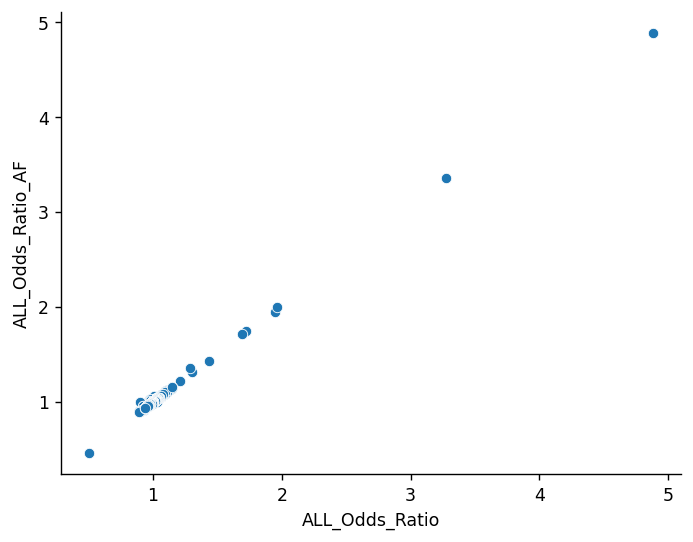

In [165]:
sns.scatterplot(data=FQ_combined_compare_encodeAF.query("Drug=='Levofloxacin'"),
                x='ALL_Odds_Ratio',
                y='ALL_Odds_Ratio_AF'
               )

sns.despine()
plt.show()

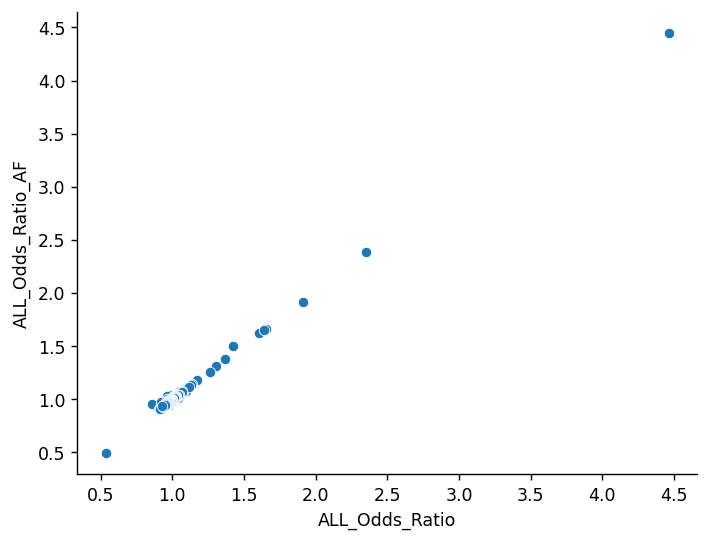

In [166]:
sns.scatterplot(data=FQ_combined_compare_encodeAF.query("Drug=='Moxifloxacin'"),
                x='ALL_Odds_Ratio',
                y='ALL_Odds_Ratio_AF'
               )

sns.despine()
plt.show()

# SOLO vs. Regression Counts Comparison Tables

In [41]:
def make_solo_regression_comparison_table(drug, solo_results, folder="FINAL", silent=True):

    silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']
    
    df = pd.read_csv(f"../results/{folder}/{drug}.csv")
    solo_results_single_drug = solo_results.query("drug==@drug & tier == 1").rename(columns={"FINAL CONFIDENCE GRADING": "SOLO"})

    if not silent:
        df = df.query("predicted_effect not in @silent_lst")
        solo_results_single_drug = solo_results_single_drug.query("effect not in @silent_lst")

    # combine with solo results
    df = solo_results_single_drug[["variant", "SOLO"]].merge(df[["mutation", "FINAL CONFIDENCE GRADING"]].rename(columns={"mutation": "variant"}), 
                                                                                on="variant", how="inner"
                                                                               )

    # create a mapping between the categories of the SOLO algorithm and regression so that they can be compared
    confidence_mapping = {"Assoc w R": "1) Assoc w R",
                          "Assoc w R - Interim": "2) Assoc w R - Interim",
                          "Uncertain": "3) Uncertain significance",
                          "Assoc w S - Interim": "4) Not assoc w R - Interim",
                          # "Neutral - Interim": "4) Not assoc w R - Interim",
                          "Assoc w S": "5) Not assoc w R",
                          "Neutral": "5) Not assoc w R",
                          }

    # all pairs (exhaustive list, so 5 x 5)
    pairs = list(itertools.product(np.unique(list(confidence_mapping.values())), np.unique(list(confidence_mapping.values()))))
    
    # add new column denoting the gradings of the regression model, if they were transformed to the list they use
    df["REGRESSION"] = df["FINAL CONFIDENCE GRADING"].map(confidence_mapping)
    assert len(df.loc[pd.isnull(df["REGRESSION"])]) == 0
    del df["FINAL CONFIDENCE GRADING"]
    
    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[["SOLO", "REGRESSION"]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
    
        if len(counts_df.query("SOLO==@a & REGRESSION==@b")) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({"SOLO": a, 
                                                            "REGRESSION": b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    # return both the dataframe of mutation and the summary counts dataframe 
    return df, counts_df.pivot(index="REGRESSION", columns="SOLO", values="count").fillna(0).astype(int)




def plot_comparison_heatmap(df, saveName=None):

    fig, ax = plt.subplots(figsize=(5, 5))
    
    sns.heatmap(
                data=df,
                cmap=sns.light_palette("teal", as_cmap=True),
                vmin=0,
                vmax=300,
                cbar=False,
                square=True,
                annot=True,
                annot_kws={"size": 10},
                fmt='g',
                linewidths=0.25, 
                linecolor='black',
                ax=ax,
                clip_on=False
               )
    
    plt.xlabel(df.columns.name)
    plt.xticks(fontsize=8, rotation=50, horizontalalignment='right')
    
    plt.yticks(fontsize=8)
    plt.ylabel(df.index.name)
    plt.tight_layout()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName)

## Non-Silent Mutations Only

In [42]:
comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

for drug in drugs_lst:
    
    _, counts_df = make_solo_regression_comparison_table(drug, solo_results, folder="FINAL", silent=False)
    comparison_tables[drug] = counts_df
    
summed_variants_across_drugs_noSilent = reduce(lambda x, y: x.add(y, fill_value=0), list(comparison_tables.values()))
summed_variants_across_drugs_noSilent

SOLO,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
REGRESSION,,,,,
1) Assoc w R,253,204,149,0,0
2) Assoc w R - Interim,0,75,74,0,1
3) Uncertain significance,0,848,14537,32,152
4) Not assoc w R - Interim,0,0,9,1,5
5) Not assoc w R,0,3,189,8,31


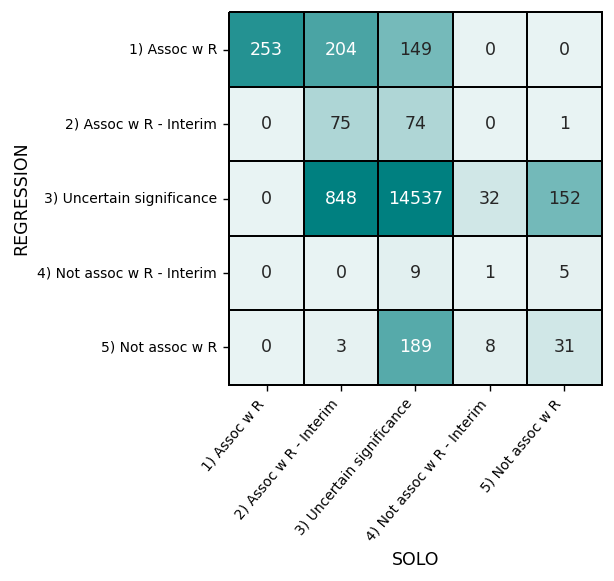

In [43]:
plot_comparison_heatmap(summed_variants_across_drugs_noSilent, "../results/Figures/solo_regression_tier1_heatmap_noSilent.png")

## All Mutations

In [44]:
comparison_tables = {}

confidence_mapping = {'1) Assoc w R': "Assoc w R - strict",
                           "2) Assoc w R - Interim": "Possible Assoc w R",
                           "3) Uncertain significance": "Uncertain",
                           "4) Not assoc w R - Interim": "Possible Assoc w S",
                           '5) Not assoc w R': "Assoc w S - strict"
                          }

for drug in drugs_lst:
    
    _, counts_df = make_solo_regression_comparison_table(drug, solo_results, folder="FINAL", silent=True)
    comparison_tables[drug] = counts_df
    
summed_variants_across_drugs = reduce(lambda x, y: x.add(y, fill_value=0), list(comparison_tables.values()))
summed_variants_across_drugs.to_csv("../results/all_variants_comparison.csv")
summed_variants_across_drugs

SOLO,1) Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim,5) Not assoc w R
REGRESSION,,,,,
1) Assoc w R,253,204,149,1,0
2) Assoc w R - Interim,0,75,74,0,1
3) Uncertain significance,0,848,14537,4937,210
4) Not assoc w R - Interim,0,0,9,1,5
5) Not assoc w R,0,3,189,59,34


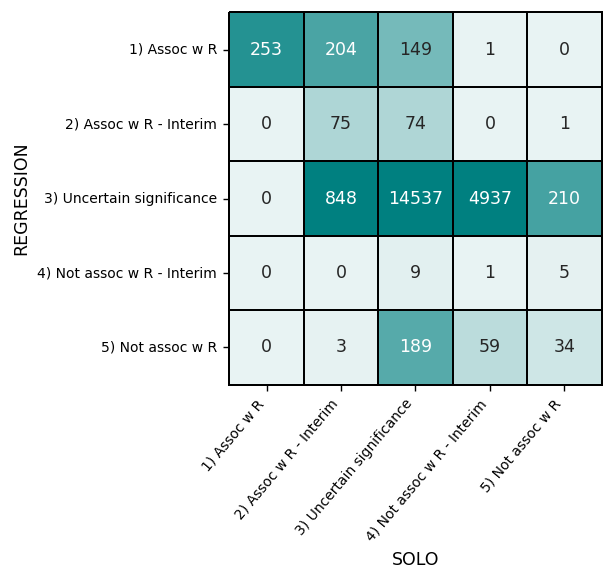

In [45]:
plot_comparison_heatmap(summed_variants_across_drugs, "../results/Figures/solo_regression_tier1_heatmap.png")

In [46]:
results_all_drugs.loc[(results_all_drugs['FINAL CONFIDENCE GRADING']=='Assoc w R - Interim') & (results_all_drugs['SOLO FINAL CONFIDENCE GRADING']=='5) Not assoc w R')]

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,WHO_BH_LRT_neutral_pval,...,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,ALL_single_lineage,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Drug
168,rrs_n.514A>C,non_coding_transcript_exon_variant,1.125086,0.0,0.0,0.999,1.0,0.003099,0.999575,1.0,...,0.974569,0.979423,Assoc w R,NaN,Assoc w R - Interim,Upgrade using ALL Evidence,Assoc w R - Interim,Assoc w R - Interim,5) Not assoc w R,Capreomycin


In [47]:
results_all_drugs.loc[(results_all_drugs['FINAL CONFIDENCE GRADING']=='Assoc w R') & (results_all_drugs['SOLO FINAL CONFIDENCE GRADING']=='4) Not assoc w R - Interim')]

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,WHO_BH_LRT_neutral_pval,...,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,ALL_single_lineage,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Drug
17758,katG_c.12A>G,synonymous_variant,1.102405,0.0,0.0,1.0,1.0,0.004395,0.999866,1.0,...,0.999866,1.0,Assoc w R,NaN,Assoc w R,WHO ALL Same Grading,Assoc w R,Assoc w R,4) Not assoc w R - Interim,Isoniazid


In [48]:
search_lst = results_all_drugs.loc[(results_all_drugs['FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Neutral'])) & (results_all_drugs['SOLO FINAL CONFIDENCE GRADING']=='2) Assoc w R - Interim')].mutation.values

results_all_drugs.loc[(results_all_drugs['FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Neutral'])) & (results_all_drugs['SOLO FINAL CONFIDENCE GRADING']=='2) Assoc w R - Interim')]

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,WHO_BH_LRT_neutral_pval,...,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,ALL_single_lineage,UNPOOLED CONFIDENCE GRADING,Reason,POOLED CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Drug
98,ethA_p.Arg463fs,frameshift,0.988052,0.323,0.498618,0.269,0.897493,0.902718,0.423602,1.000000,...,0.990254,0.993162,Neutral,NaN,Neutral,Neutral in ALL,Neutral,Neutral,2) Assoc w R - Interim,Ethionamide
572,rpoB_p.Asn437Asp,missense_variant,0.969716,0.026,0.104892,0.967,1.000000,0.115818,0.987864,1.000000,...,0.999575,0.999928,Neutral,NaN,Neutral,Neutral in ALL,Neutral,Neutral,2) Assoc w R - Interim,Rifampicin
20527,rpoB_p.Lys446Gln,missense_variant,0.988627,0.273,0.513815,0.490,0.800139,1.000000,0.523874,0.673801,...,0.999765,0.999992,Neutral,NaN,Neutral,Pooled Unpooled Different,Uncertain,Neutral,2) Assoc w R - Interim,Rifampicin


In [123]:
results_all_drugs.loc[(results_all_drugs['FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Neutral'])) & (results_all_drugs['SOLO FINAL CONFIDENCE GRADING']=='2) Assoc w R - Interim')][['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval']]

,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval
461,ethA_p.Arg463fs,0.988052,0.498618,1.036471,0.052510
803,rpoB_p.Lys446Gln,0.988627,0.513815,0.998989,0.639102
1038,rpoB_p.Asn437Asp,0.969716,0.104892,1.001678,0.581643


In [3]:
def count_cooccurring_mutations(drug, gene, variant_of_interest, df_genos):

    isolates_with_variant = df_genos.query("resolved_symbol==@gene & variant_category==@variant_of_interest & variant_binary_status==1").sample_id.unique()
    print(f"{len(isolates_with_variant)} isolates with {variant_of_interest}")

    isolates_with_variant_and_nonsyn = df_genos.query("sample_id in @isolates_with_variant & variant_binary_status==1 & variant_category != @variant_of_interest & predicted_effect != 'synonymous_variant'").sample_id.unique()
    print(f"{len(isolates_with_variant_and_nonsyn)} isolates with {variant_of_interest} and another nonsynonymous mutation")

    cat12_muts = solo_results.query("drug==@drug").loc[solo_results["FINAL CONFIDENCE GRADING"].isin(['1) Assoc w R', '2) Assoc w R - Interim'])].mutation.values
    
    isolates_with_variant_and_Rassoc = df_genos.query("sample_id in @isolates_with_variant & variant_binary_status==1 & variant_category != @variant_of_interest & variant_category in @cat12_muts").sample_id.unique()
    print(f"{len(isolates_with_variant_and_Rassoc)} isolates with {variant_of_interest} and another R-associated or interim mutation")

    # return isolates that have the variant but not any other R-associated or interim mutation
    if len(list(set(isolates_with_variant) - set(isolates_with_variant_and_Rassoc))) == 0:
        return None
    else:
        return list(set(isolates_with_variant) - set(isolates_with_variant_and_Rassoc))

In [12]:
count_cooccurring_mutations("Rifampicin", 'p.Ile491Thr', RIF_genos)

9 isolates with p.Ile491Thr
9 isolates with p.Ile491Thr and another nonsynonymous mutation
9 isolates with p.Ile491Thr and another R-associated or interim mutation


In [13]:
remaining_isolates = count_cooccurring_mutations("Rifampicin", 'p.Ile491Met', RIF_genos)

20 isolates with p.Ile491Met
16 isolates with p.Ile491Met and another nonsynonymous mutation
16 isolates with p.Ile491Met and another R-associated or interim mutation


In [206]:
neutral_by_literature = pd.read_excel("../data/NotAwR by literature.xlsx")
neutral_by_literature.columns = ['Drug', 'mutation']
neutral_by_literature['Gene'] = [val.split('_')[0] for val in neutral_by_literature.mutation.values]

drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")

neutral_by_literature = neutral_by_literature.merge(drug_gene_mapping, on=['Drug', 'Gene'], how='left')
assert len(neutral_by_literature.loc[pd.isnull(neutral_by_literature['Tier'])]) == 0
neutral_by_literature = neutral_by_literature.query("Tier==1")
print(neutral_by_literature.shape)

# combine with regression results to see what the classifications / stats are for non-neutral mutations
neutral_comparison = neutral_by_literature.merge(results_all_drugs, on=["Drug", "mutation"], how="left")
print(neutral_comparison.shape)

(28, 4)
(28, 64)


# Analyze the S-Associated Variants

In [64]:
# nonSilent_susceptible_neutral = results_all_drugs.loc[results_all_drugs['FINAL CONFIDENCE GRADING'].isin(['Assoc w S', 'Assoc w S - Interim', 'Neutral'])].query("predicted_effect not in @silent_lst")
susceptible_variants = results_all_drugs.loc[results_all_drugs['FINAL CONFIDENCE GRADING'].str.contains('Assoc w S')]

all_MIC_results = []

for drug in drugs_lst:
    single_drug_MIC_results = pd.concat([pd.read_csv(os.path.join(analysis_dir, drug, f"MIC/tiers=1/{model_path}/model_analysis.csv")) for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolSeparate", "dropAF_withSyn_unpooled"]]).drop_duplicates("mutation", keep="first")

    # fix LoF naming for merging
    single_drug_MIC_results["mutation"] = [val.replace("lof", "LoF") for val in single_drug_MIC_results.mutation.values]
    single_drug_MIC_results["Drug"] = drug
    single_drug_MIC_results = single_drug_MIC_results.rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})[['Drug', 'mutation', 'MIC_coef', 'MIC_BH_pval']]
    
    all_MIC_results.append(single_drug_MIC_results)

all_MIC_results = pd.concat(all_MIC_results)

# add MIC results to the binary dataframe
susceptible_variants = susceptible_variants.merge(all_MIC_results, on=['Drug', 'mutation'], how='left')
print(susceptible_variants.shape)

susceptible_variants.sort_values(["Drug", "ALL_Odds_Ratio"], ascending=[True, True])[['Drug', 'mutation', 'predicted_effect', 'ALL_Odds_Ratio', 'MIC_coef', 'MIC_BH_pval', 'FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].to_csv("/home/sak0914/who-analysis/results/susceptible_assoc_variants.csv", index=False)

(24, 64)
